In [2]:
from sql.future_data_manager import FuturesDataManager
from custom_indicators.force_indicator import ForceIndex
import backtrader as bt
%matplotlib inline

In [3]:
fdm = FuturesDataManager()


In [4]:
update_number = fdm.update_all_main_contracts_data(start_date = '20150101')
print(f"更新数量：{update_number}")

更新数量：147328


In [5]:
data_df = fdm.query_data(symbol='CF0', start_date='2024-01-01', end_date='2025-12-31')
data_df.head()

,id,symbol,exchange,name,date,open,high,low,close,volume,open_interest,settlement_price,data_type,created_time,updated_time
0,250500,CF0,czce,棉花连续,2025-10-31,13605.0,13670.0,13585.0,13595.0,177483,578141,13635.0,main_continuous,2025-11-02 03:21:38,2025-11-02 03:21:38
1,250499,CF0,czce,棉花连续,2025-10-30,13640.0,13675.0,13570.0,13600.0,211342,577586,13630.0,main_continuous,2025-11-02 03:21:38,2025-11-02 03:21:38
2,250498,CF0,czce,棉花连续,2025-10-29,13555.0,13625.0,13520.0,13620.0,185465,578488,13585.0,main_continuous,2025-11-02 03:21:38,2025-11-02 03:21:38
3,250497,CF0,czce,棉花连续,2025-10-28,13565.0,13590.0,13540.0,13565.0,121915,579084,13565.0,main_continuous,2025-11-02 03:21:38,2025-11-02 03:21:38
4,250496,CF0,czce,棉花连续,2025-10-27,13550.0,13635.0,13530.0,13565.0,183256,585287,13575.0,main_continuous,2025-11-02 03:21:38,2025-11-02 03:21:38


In [3]:
class TestStrategy(bt.Strategy):
    def __init__(self):
        self.force_index = ForceIndex(self.data)

In [4]:
import pandas as pd


def plot_force_index_simple(df):
    """简化版本的绘图函数，避免版本兼容性问题"""
    
    # 创建Cerebro引擎
    cerebro = bt.Cerebro()
    
    # 添加策略
    cerebro.addstrategy(TestStrategy)
    
    # 准备数据 - 确保日期格式正确
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    df = df.sort_index()  # 按时间排序
    
    data = bt.feeds.PandasData(
        dataname=df,
        open='open',
        high='high',
        low='low',
        close='close',
        volume='volume',
        openinterest=None
    )
    
    # 添加数据到Cerebro
    cerebro.adddata(data)
    
    # 设置初始资金
    cerebro.broker.setcash(100000.0)
    
    print('初始资金: %.2f' % cerebro.broker.getvalue())
    print('开始回测...')
    
    # 运行回测
    results = cerebro.run()
    
    # 绘制图表 - 使用更兼容的方式
    cerebro.plot(style='candle', volume=False, iplot=False)
    
    return results

# 如果您已经有DataFrame，使用这个函数
def plot_with_existing_data(df):
    """使用现有DataFrame数据绘图的主函数"""
    
    print("数据预览:")
    print(df.head())
    print(f"\n数据形状: {df.shape}")
    
    # 检查必要的列是否存在
    required_cols = ['date', 'open', 'high', 'low', 'close', 'volume']
    missing_cols = [col for col in required_cols if col not in df.columns]
    
    if missing_cols:
        print(f"缺少必要的列: {missing_cols}")
        return
    
    try:
        # 方法2: 绘制图表
        print("\n绘制图表...")
        plot_force_index_simple(df)
        
    except Exception as e:
        print(f"发生错误: {e}")
        print("尝试替代方法...")

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_manual_force_index(df):
    """手动计算并绘制强力指标"""
    
    # 准备数据
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)
    
    # 计算强力指标
    df['price_change'] = df['close'] - df['close'].shift(1)
    df['log_volume'] = np.log1p(df['volume'])
    df['raw_force'] = df['price_change'] * df['log_volume']
    df['force_index'] = df['raw_force'].ewm(span=3).mean()
    
    # 创建图表
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    
    # 1. K线图（简化版）
    ax1.plot(df['date'], df['close'], label='Close Price', color='black', linewidth=2)
    ax1.fill_between(df['date'], df['low'], df['high'], alpha=0.3, color='gray')
    ax1.set_title('Price Chart')
    ax1.set_ylabel('Price')
    ax1.legend()
    ax1.grid(True)
    
    # 2. 成交量
    ax2.bar(df['date'], df['volume'], color='blue', alpha=0.7, label='Volume')
    ax2.set_ylabel('Volume')
    ax2.legend()
    ax2.grid(True)
    
    # 3. 强力指标
    ax3.plot(df['date'], df['force_index'], label='Force Index', color='red', linewidth=2)
    ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax3.set_ylabel('Force Index')
    ax3.set_xlabel('Date')
    ax3.legend()
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # 打印指标值
    print("强力指标数值:")
    for i, row in df.iterrows():
        if not pd.isna(row['force_index']):
            print(f"{row['date'].strftime('%Y-%m-%d')}: {row['force_index']:.2f}")
    
    return df


In [ ]:
# plot_with_existing_data(df=data_df)
%matplotlib inline
plot_force_index_simple(df= data_df)

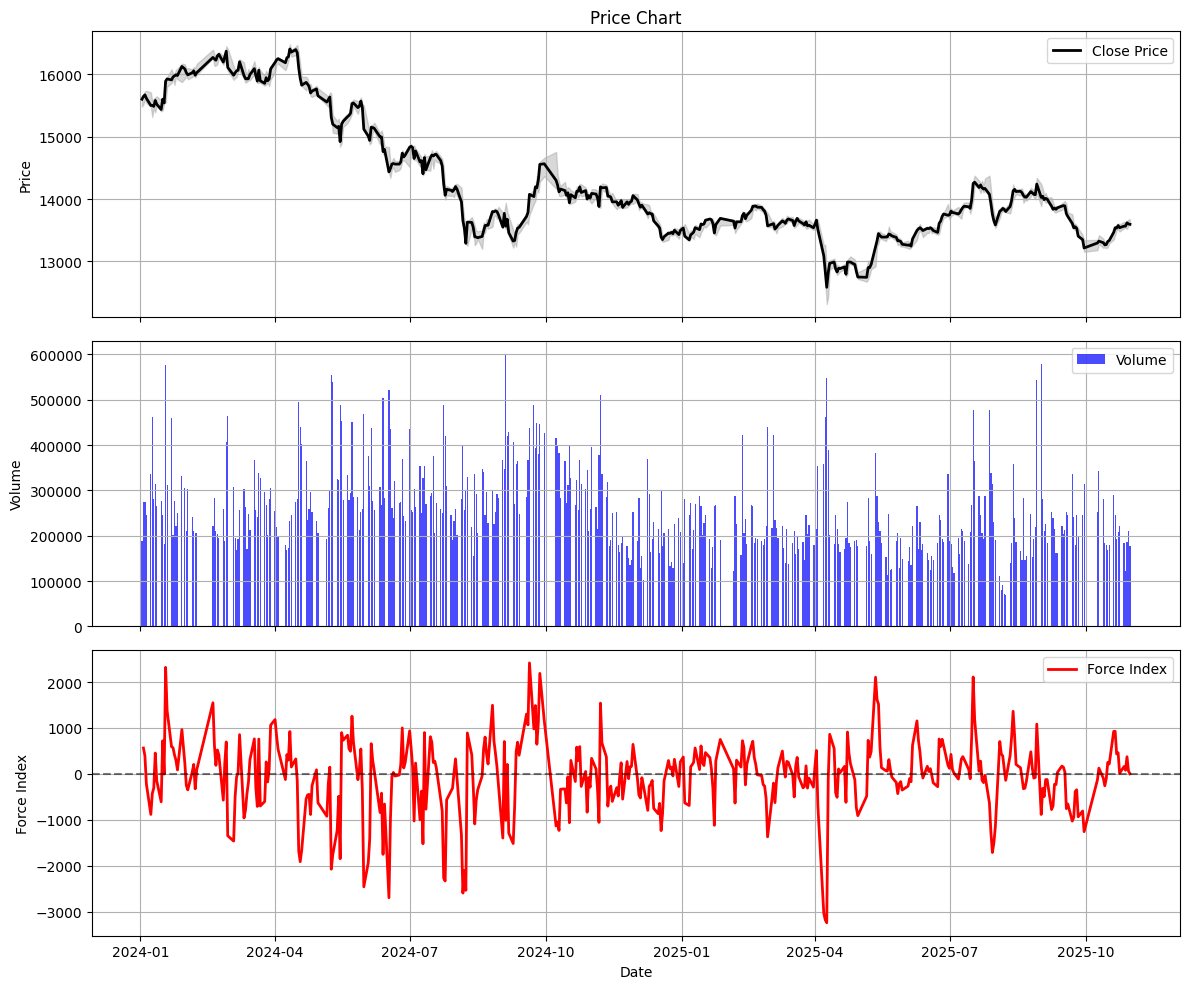

强力指标数值:
2024-01-03: 563.44
2024-01-04: 396.51
2024-01-05: -220.12
2024-01-08: -883.02
2024-01-09: -427.27
2024-01-10: -305.82
2024-01-11: 454.20
2024-01-12: -149.84
2024-01-15: -608.41
2024-01-16: 720.85
2024-01-17: -3.14
2024-01-18: 2320.66
2024-01-19: 1381.54
2024-01-22: 592.94
2024-01-23: 571.24
2024-01-24: 410.93
2024-01-25: 297.77
2024-01-26: 86.73
2024-01-29: 965.06
2024-01-31: 229.96
2024-02-01: -252.75
2024-02-02: -347.29
2024-02-05: 43.21
2024-02-06: 205.54
2024-02-07: -325.54
2024-02-08: 82.04
2024-02-19: 1549.23
2024-02-20: 617.66
2024-02-21: 186.29
2024-02-22: 521.00
2024-02-23: 412.77
2024-02-26: -572.82
2024-02-27: 229.92
2024-02-28: 696.18
2024-02-29: -1348.15
2024-03-04: -1463.72
2024-03-05: -488.16
2024-03-06: -63.65
2024-03-07: 29.04
2024-03-08: 855.07
2024-03-11: -960.63
2024-03-12: -792.35
2024-03-13: -426.30
2024-03-14: -182.10
2024-03-15: 307.75
2024-03-18: 762.42
2024-03-19: -303.72
2024-03-20: -709.43
2024-03-21: 759.13
2024-03-22: -699.68
2024-03-25: -601.86
20

,id,symbol,exchange,name,date,open,high,low,close,volume,open_interest,settlement_price,data_type,created_time,updated_time,price_change,log_volume,raw_force,force_index
0,17154,CF0,czce,棉花连续,2024-01-02,15510.0,15630.0,15480.0,15600.0,188206,672453,15555.0,main_continuous,2025-09-17 09:34:27,2025-11-02 03:21:38,NaN,12.145298,NaN,NaN
1,17155,CF0,czce,棉花连续,2024-01-03,15615.0,15670.0,15520.0,15645.0,273981,661036,15595.0,main_continuous,2025-09-17 09:34:27,2025-11-02 03:21:38,45.0,12.520818,563.436796,563.436796
2,17156,CF0,czce,棉花连续,2024-01-04,15645.0,15725.0,15600.0,15670.0,274292,661258,15665.0,main_continuous,2025-09-17 09:34:27,2025-11-02 03:21:38,25.0,12.521952,313.048804,396.511468
3,17157,CF0,czce,棉花连续,2024-01-05,15700.0,15735.0,15540.0,15615.0,245409,648974,15630.0,main_continuous,2025-09-17 09:34:27,2025-11-02 03:21:38,-55.0,12.410686,-682.587706,-220.116631
4,17158,CF0,czce,棉花连续,2024-01-08,15615.0,15710.0,15480.0,15500.0,335132,633875,15575.0,main_continuous,2025-09-17 09:34:27,2025-11-02 03:21:38,-115.0,12.722283,-1463.062516,-883.021103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,250496,CF0,czce,棉花连续,2025-10-27,13550.0,13635.0,13530.0,13565.0,183256,585287,13575.0,main_continuous,2025-11-02 03:21:38,2025-11-02 03:21:38,25.0,12.118645,302.966120,159.270318
436,250497,CF0,czce,棉花连续,2025-10-28,13565.0,13590.0,13540.0,13565.0,121915,579084,13565.0,main_continuous,2025-11-02 03:21:38,2025-11-02 03:21:38,0.0,11.711088,0.000000,79.635159
437,250498,CF0,czce,棉花连续,2025-10-29,13555.0,13625.0,13520.0,13620.0,185465,578488,13585.0,main_continuous,2025-11-02 03:21:38,2025-11-02 03:21:38,55.0,12.130627,667.184477,373.409818
438,250499,CF0,czce,棉花连续,2025-10-30,13640.0,13675.0,13570.0,13600.0,211342,577586,13630.0,main_continuous,2025-11-02 03:21:38,2025-11-02 03:21:38,-20.0,12.261238,-245.224754,64.092532


In [10]:
# 使用手动绘制
plot_manual_force_index(data_df)